In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

from matplotlib.patches import Patch

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [14]:
# Get the current working directory
print("Current working directory:", os.getcwd())

# Use absolute path
data_path = Path("/home/rizfn/github/babel-transition/src/dataAnalysis/grambank/data/cldf")

# Load the main tables into pandas DataFrames
languages_df = pd.read_csv(data_path / "languages.csv")
parameters_df = pd.read_csv(data_path / "parameters.csv") 
values_df = pd.read_csv(data_path / "values.csv")
codes_df = pd.read_csv(data_path / "codes.csv")

# Display basic info about the datasets
print("Languages table shape:", languages_df.shape)
print("Parameters table shape:", parameters_df.shape)
print("Values table shape:", values_df.shape)
print("Codes table shape:", codes_df.shape)

# Show first few rows
print("\nLanguages columns:", languages_df.columns.tolist())
print("Parameters columns:", parameters_df.columns.tolist())
print("Values columns:", values_df.columns.tolist())
print("Codes columns:", codes_df.columns.tolist())

Current working directory: /home/rizfn/github/babel-transition/src/dataAnalysis/grambank
Languages table shape: (2467, 13)
Parameters table shape: (195, 12)
Values table shape: (441663, 9)
Codes table shape: (398, 4)

Languages columns: ['ID', 'Name', 'Macroarea', 'Latitude', 'Longitude', 'Glottocode', 'ISO639P3code', 'provenance', 'Family_name', 'Family_level_ID', 'Language_level_ID', 'level', 'lineage']
Parameters columns: ['ID', 'Name', 'Description', 'ColumnSpec', 'Patrons', 'Grambank_ID_desc', 'Boundness', 'Flexivity', 'Gender_or_Noun_Class', 'Locus_of_Marking', 'Word_Order', 'Informativity']
Values columns: ['ID', 'Language_ID', 'Parameter_ID', 'Value', 'Code_ID', 'Comment', 'Source', 'Source_comment', 'Coders']
Codes columns: ['ID', 'Parameter_ID', 'Name', 'Description']


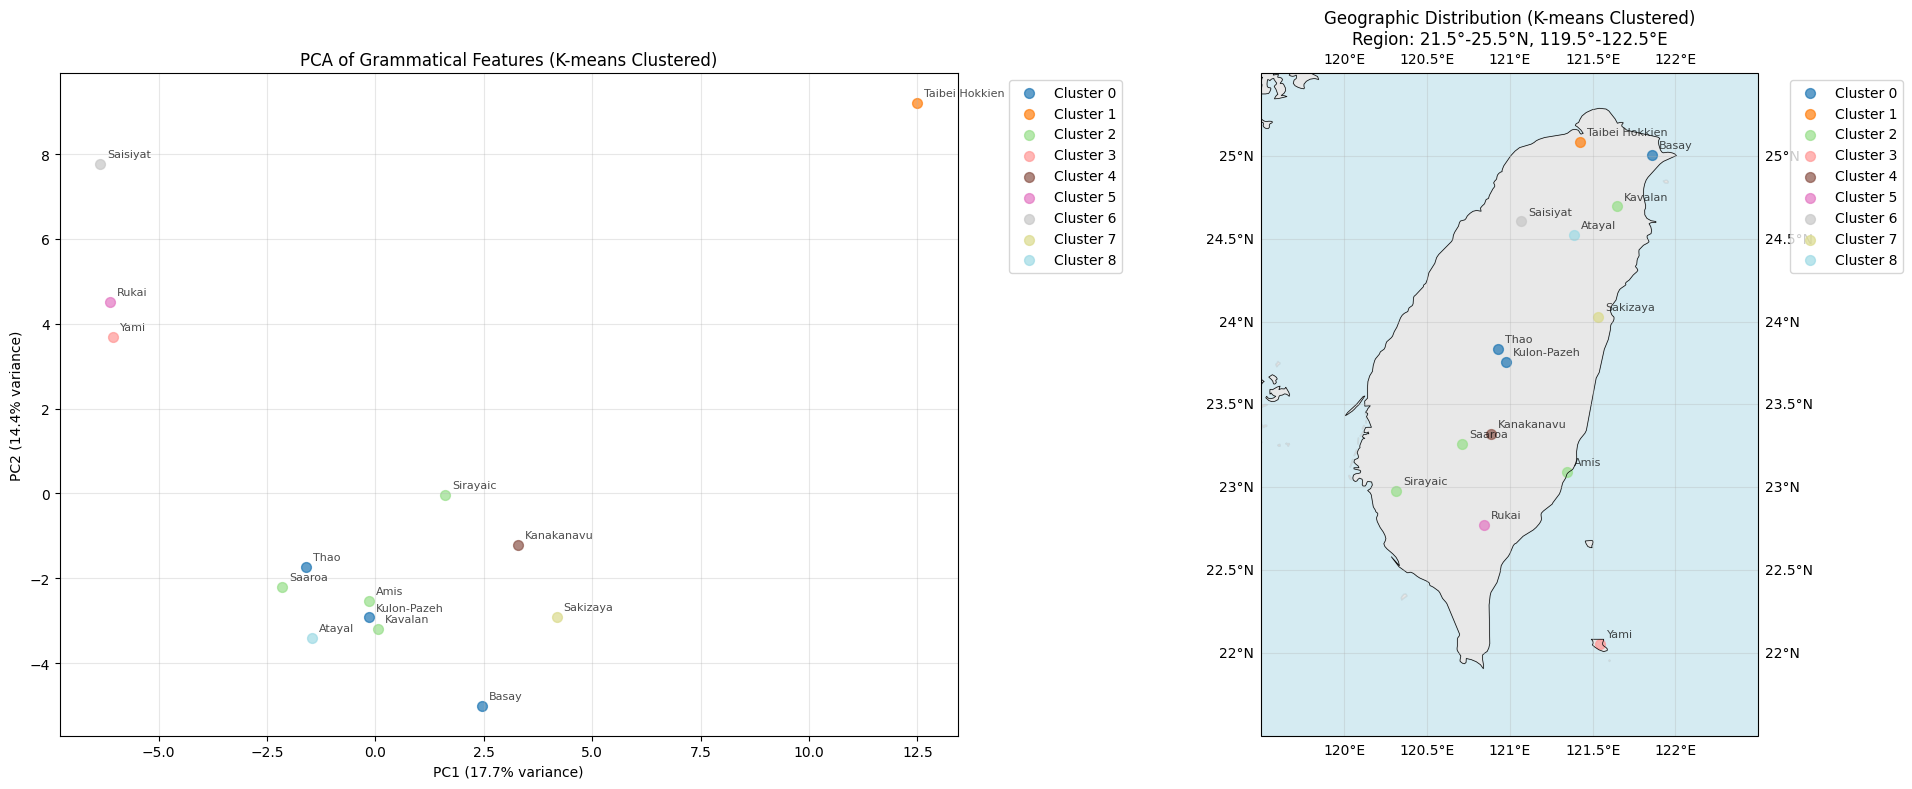

In [15]:
# Define your geographic region (lat/lon bounds)
lat_min, lat_max = 21.5, 25.5
lon_min, lon_max = 119.5, 122.5

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Create lang_coords for languages that are in our feature matrix
lang_coords = geo_languages[geo_languages['ID'].isin(feature_matrix.index)].copy()
lang_coords = lang_coords.set_index('ID').loc[feature_matrix.index].reset_index()

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Get unique clusters and assign colors using a colormap that works well for many categories
unique_clusters = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))  # tab20 has 20 distinct colors
cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Create subplot layout with cartopy projection
fig = plt.figure(figsize=(20, 8))

# Plot 1: PCA with clusters
ax1 = fig.add_subplot(1, 2, 1)
for cluster in unique_clusters:
    mask = clusters == cluster
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}')

for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    ax1.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA of Grammatical Features (K-means Clustered)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Geographic plot with coastlines
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

# Add gridlines
ax2.gridlines(draw_labels=True, alpha=0.3)

# Plot language points
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_coords = lang_coords[mask]
    
    ax2.scatter(cluster_coords['Longitude'], cluster_coords['Latitude'], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}',
               transform=ccrs.PlateCarree())

# Add language labels
for i, row in lang_coords.iterrows():
    ax2.annotate(row['Name'], (row['Longitude'], row['Latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7,
                transform=ccrs.PlateCarree())

# Set extent to your region
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax2.set_title(f'Geographic Distribution (K-means Clustered)\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

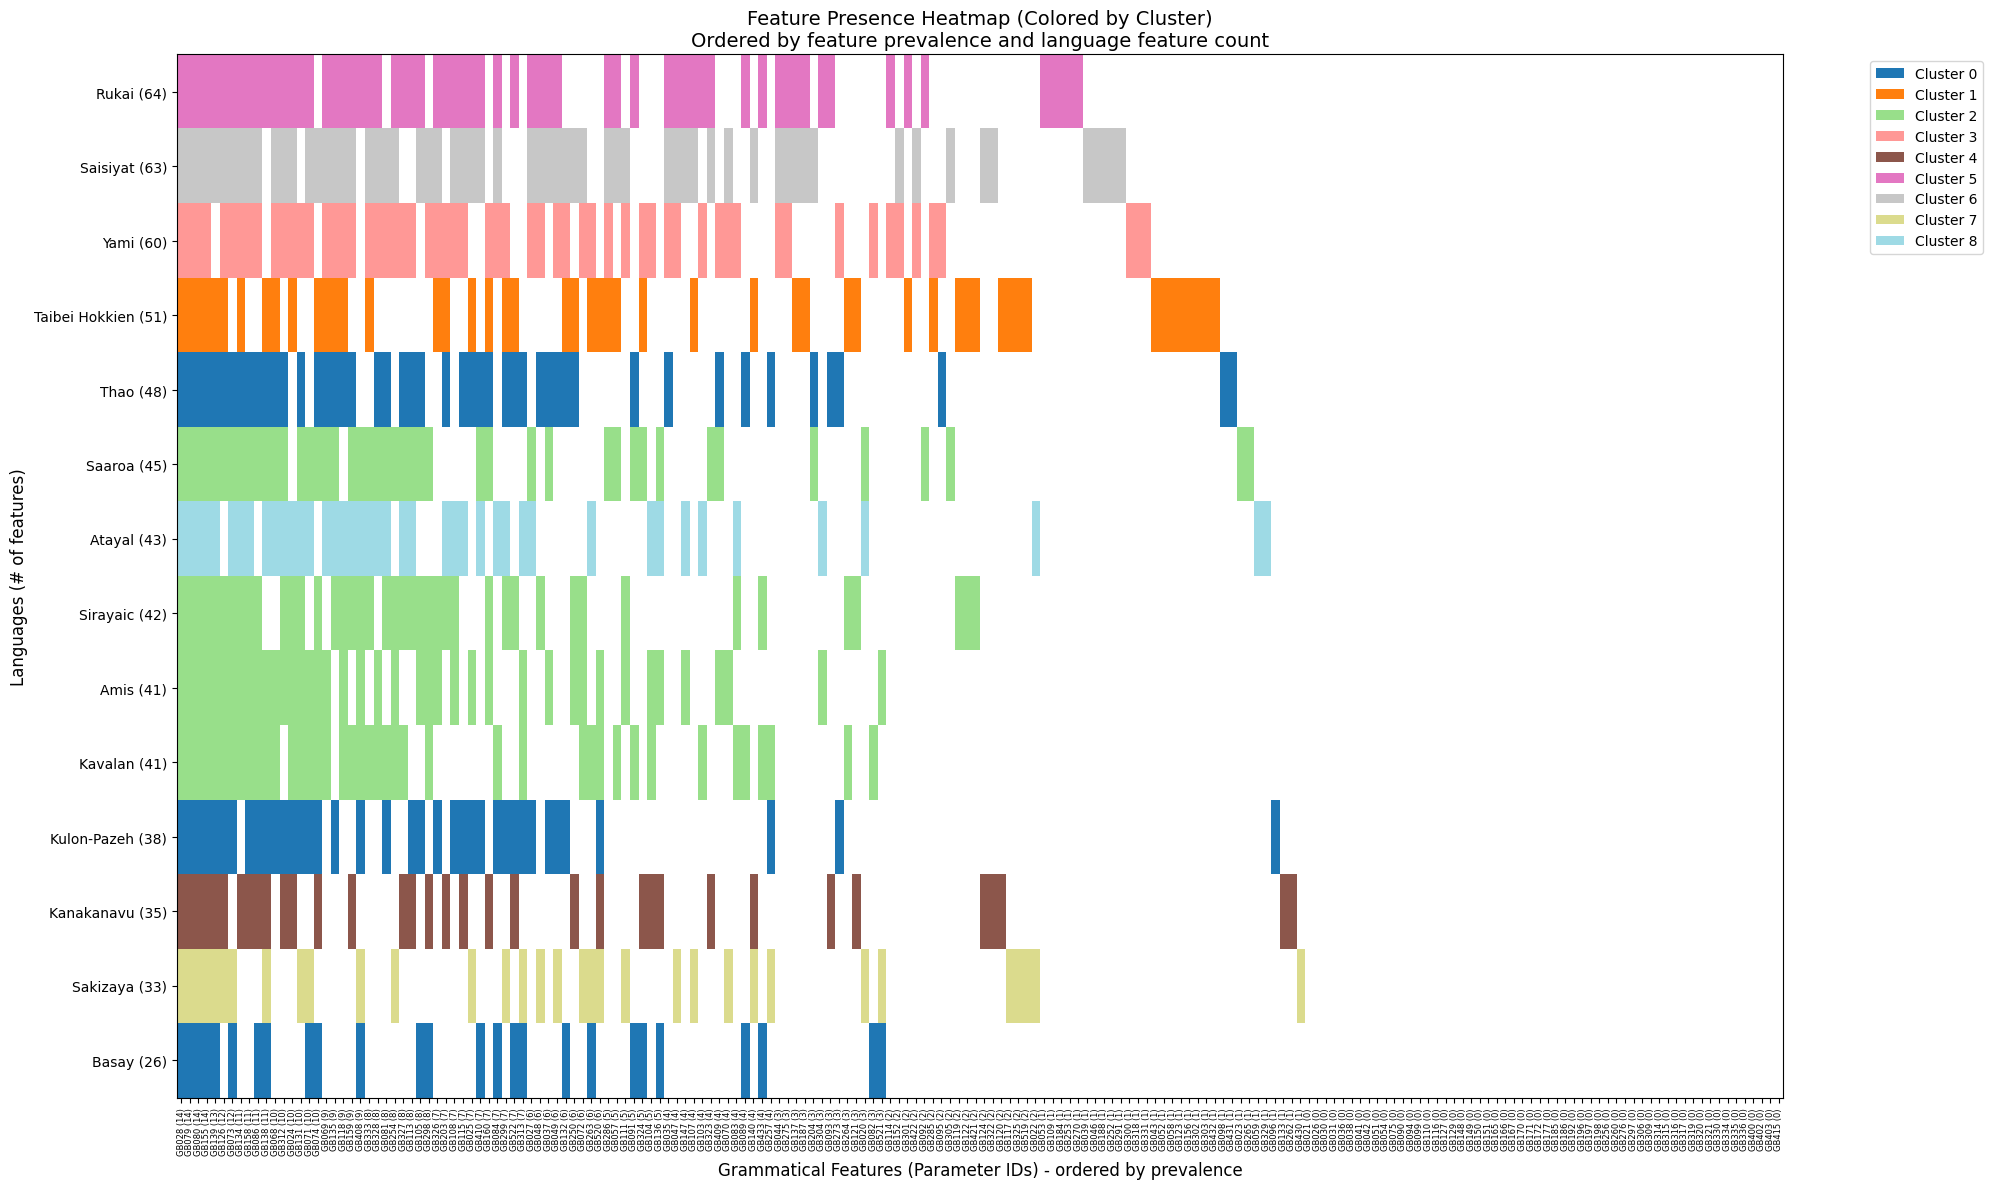

In [16]:
# Create heatmap of features by language, colored by cluster
fig, ax = plt.subplots(figsize=(20, 12))

# Order languages by total number of features they have (descending)
language_feature_counts = feature_matrix.sum(axis=1).sort_values(ascending=False)
ordered_languages = language_feature_counts.index

# Create a language ranking for tie-breaking
lang_rank = {lang_id: i for i, lang_id in enumerate(ordered_languages)}

# Order features by prevalence, with tie-breaking based on which languages have them
feature_counts = feature_matrix.sum(axis=0)

# For each feature, calculate a secondary sort key based on language rankings
feature_sort_keys = []
for feat in feature_matrix.columns:
    count = feature_counts[feat]
    # Get the languages that have this feature and sum their ranks (lower is better)
    langs_with_feature = feature_matrix[feature_matrix[feat] == 1].index
    avg_lang_rank = sum(lang_rank[lang] for lang in langs_with_feature) / len(langs_with_feature) if len(langs_with_feature) > 0 else float('inf')
    feature_sort_keys.append((feat, count, avg_lang_rank))

# Sort by count (descending), then by average language rank (ascending)
feature_sort_keys.sort(key=lambda x: (-x[1], x[2]))
ordered_features = [x[0] for x in feature_sort_keys]

# Reorder the feature matrix
feature_matrix_ordered = feature_matrix.loc[ordered_languages, ordered_features]

# Create a color array for the heatmap
# Shape: (n_languages, n_features)
heatmap_data = np.zeros((len(feature_matrix_ordered), len(feature_matrix_ordered.columns), 4))

# For each language
for i, (lang_id, row) in enumerate(feature_matrix_ordered.iterrows()):
    # Get the cluster assignment from the original ordering
    original_idx = list(feature_matrix.index).index(lang_id)
    cluster = clusters[original_idx]
    cluster_color = cluster_colors[cluster]
    
    # For each feature
    for j, value in enumerate(row):
        if value == 1:
            heatmap_data[i, j] = cluster_color
        else:
            heatmap_data[i, j] = [1, 1, 1, 1]  # White for 0 values

# Plot the heatmap
ax.imshow(heatmap_data, aspect='auto', interpolation='nearest')

# Set ticks and labels
ax.set_yticks(range(len(feature_matrix_ordered)))
ax.set_yticklabels([f"{lang_coords[lang_coords['Language_ID'] == lang_id]['Name'].iloc[0]} ({int(language_feature_counts[lang_id])})" 
                     for lang_id in ordered_languages], fontsize=10)

ax.set_xticks(range(len(feature_matrix_ordered.columns)))
ax.set_xticklabels([f"{feat} ({int(feature_counts[feat])})" for feat in ordered_features], 
                    rotation=90, fontsize=6)

ax.set_xlabel('Grammatical Features (Parameter IDs) - ordered by prevalence', fontsize=12)
ax.set_ylabel('Languages (# of features)', fontsize=12)
ax.set_title('Feature Presence Heatmap (Colored by Cluster)\nOrdered by feature prevalence and language feature count', fontsize=14)

# Add a legend for clusters
legend_elements = [Patch(facecolor=cluster_colors[cluster], label=f'Cluster {cluster}')
                   for cluster in unique_clusters]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()


Total number of bits (features): 188
	AND Similarity (shared 1s):
		Average: 22.41, Min: 9, Max: 43
	XNOR Similarity (total agreement):
		Average: 142.81, Min: 119, Max: 160


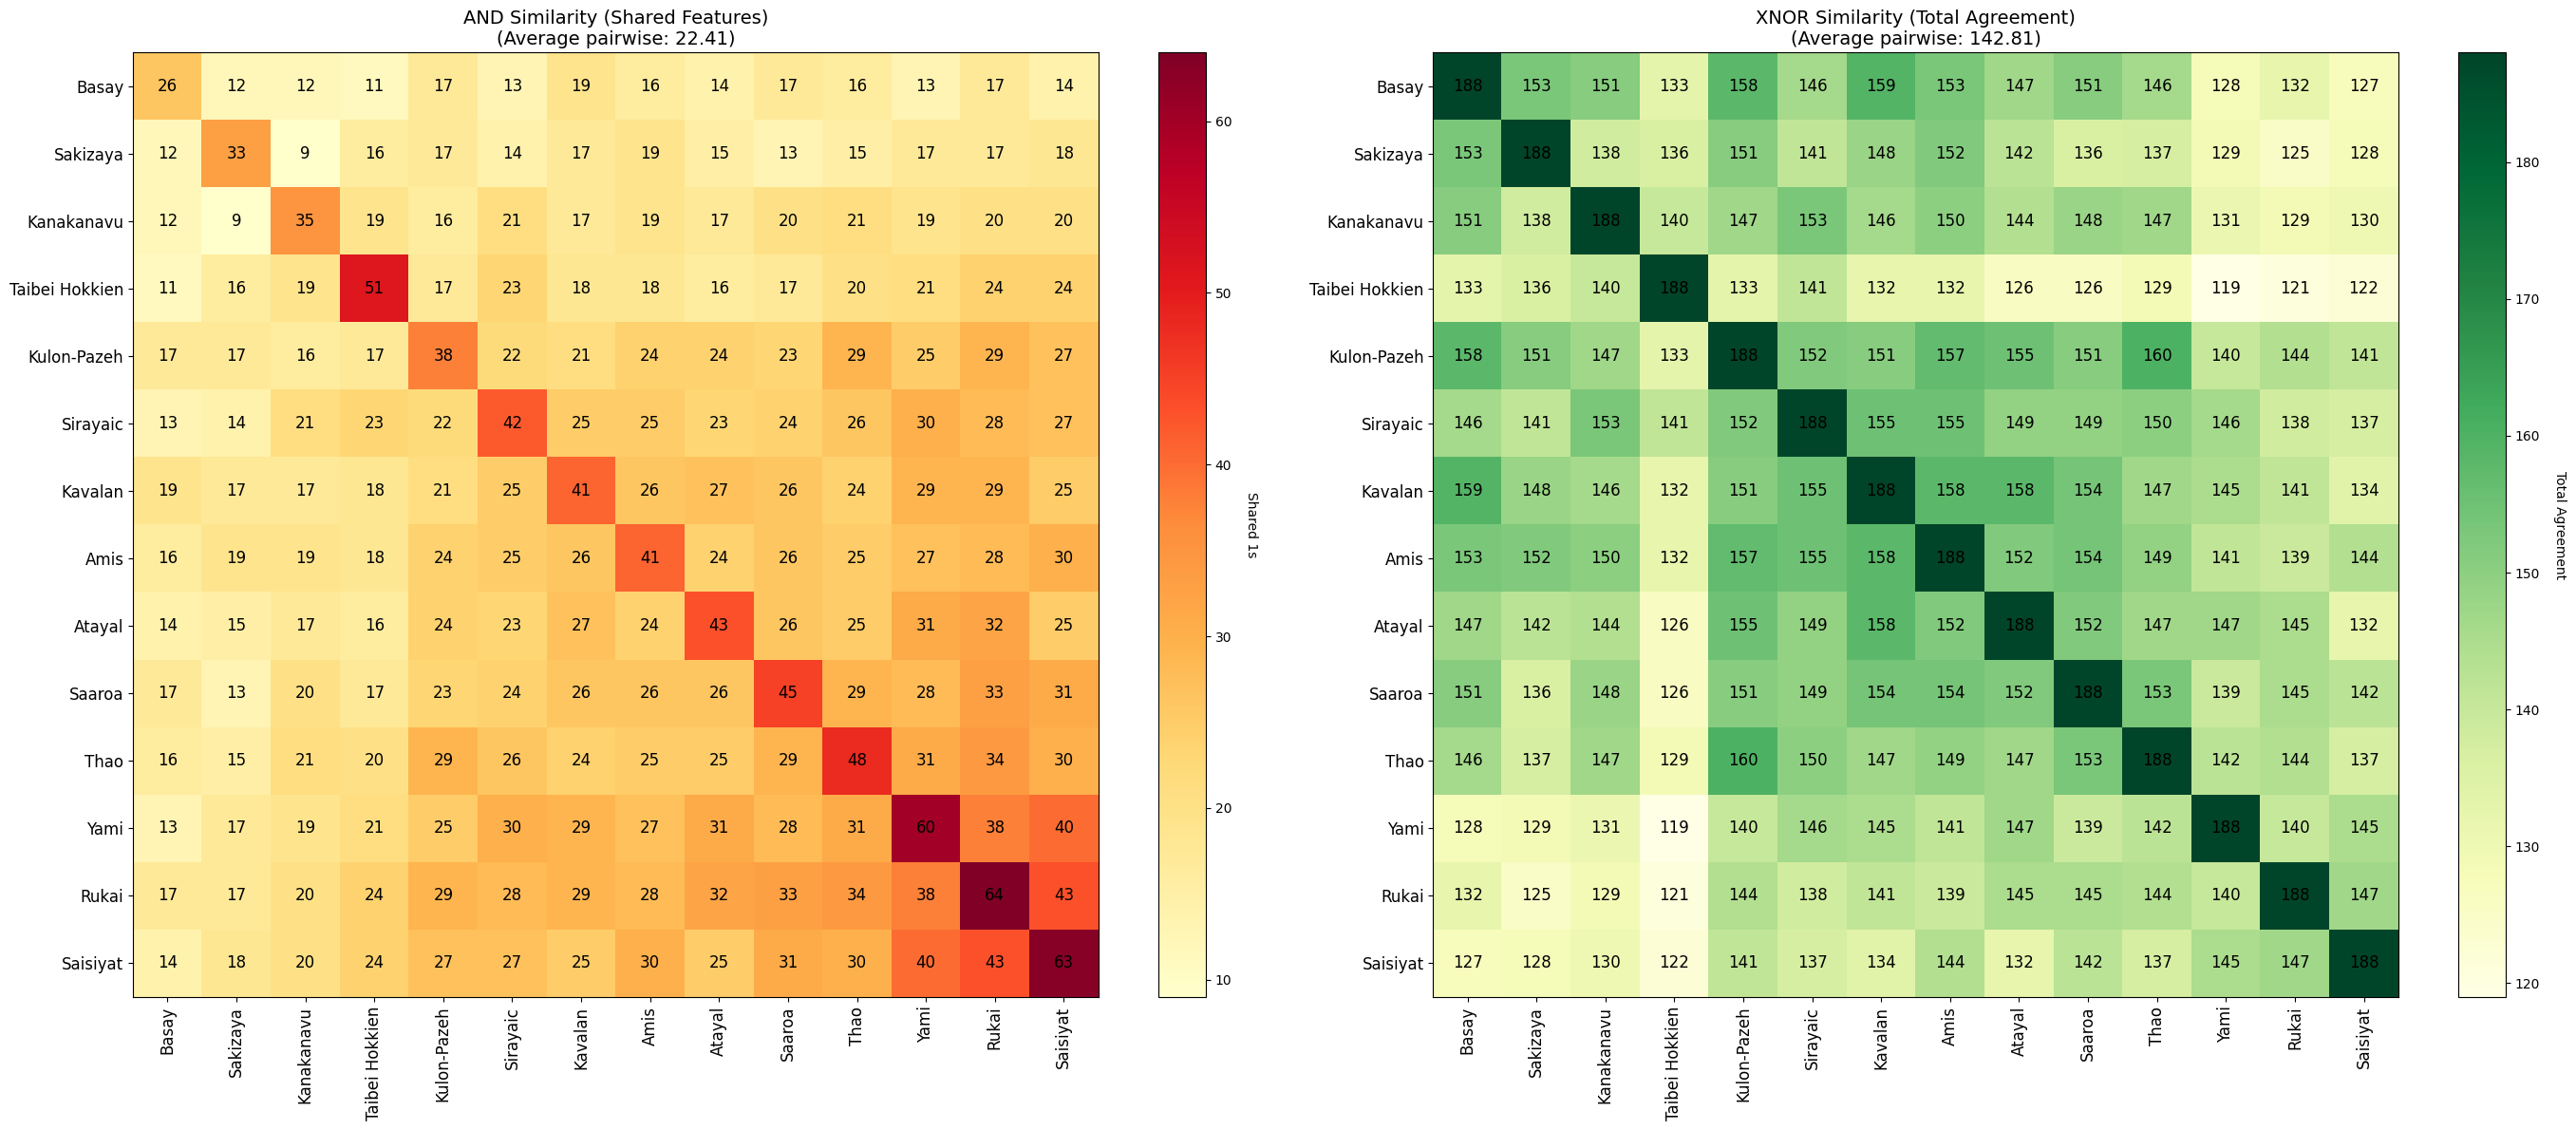

In [17]:
n_langs = len(feature_matrix)
n_features = len(feature_matrix.columns)

# Matrix 1: AND similarity (number of shared 1s)
and_similarity_matrix = np.zeros((n_langs, n_langs))

# Matrix 2: XNOR similarity (number of features where both agree - both 0 or both 1)
xnor_similarity_matrix = np.zeros((n_langs, n_langs))

# Calculate both similarity measures
for i in range(n_langs):
    for j in range(n_langs):
        if i == j:
            # Diagonal: total number of features for AND, total features for XNOR
            and_similarity_matrix[i, j] = feature_matrix.iloc[i].sum()
            xnor_similarity_matrix[i, j] = n_features
        else:
            # AND: Count features where both languages have value 1
            shared_ones = ((feature_matrix.iloc[i] == 1) & (feature_matrix.iloc[j] == 1)).sum()
            and_similarity_matrix[i, j] = shared_ones
            
            # XNOR: Count features where both agree (both 0 or both 1)
            both_zero = ((feature_matrix.iloc[i] == 0) & (feature_matrix.iloc[j] == 0)).sum()
            both_one = shared_ones
            xnor_similarity_matrix[i, j] = both_zero + both_one

# Calculate average pairwise similarities (excluding diagonal)
upper_triangle_indices = np.triu_indices(n_langs, k=1)

and_pairwise = and_similarity_matrix[upper_triangle_indices]
avg_and = and_pairwise.mean()

xnor_pairwise = xnor_similarity_matrix[upper_triangle_indices]
avg_xnor = xnor_pairwise.mean()

print(f"Total number of bits (features): {n_features}")
print(f"\tAND Similarity (shared 1s):")
print(f"\t\tAverage: {avg_and:.2f}, Min: {and_pairwise.min():.0f}, Max: {and_pairwise.max():.0f}")
print(f"\tXNOR Similarity (total agreement):")
print(f"\t\tAverage: {avg_xnor:.2f}, Min: {xnor_pairwise.min():.0f}, Max: {xnor_pairwise.max():.0f}")

# Use hierarchical clustering on AND similarity for ordering
max_similarity = and_similarity_matrix.max()
distance_matrix = max_similarity - and_similarity_matrix
np.fill_diagonal(distance_matrix, 0)

linkage_matrix = linkage(squareform(distance_matrix), method='average')
dendro = dendrogram(linkage_matrix, no_plot=True)
sorted_indices = dendro['leaves']

# Reorder both matrices with the same ordering
and_matrix_sorted = and_similarity_matrix[sorted_indices, :][:, sorted_indices]
xnor_matrix_sorted = xnor_similarity_matrix[sorted_indices, :][:, sorted_indices]

lang_names = [lang_coords[lang_coords['Language_ID'] == lang_id]['Name'].iloc[0] for lang_id in feature_matrix.index]
lang_names_sorted = [lang_names[i] for i in sorted_indices]

# Create side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))

# Plot 1: AND similarity
im1 = ax1.imshow(and_matrix_sorted, cmap='YlOrRd', aspect='auto')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Shared 1s', rotation=270, labelpad=20)

ax1.set_xticks(range(n_langs))
ax1.set_yticks(range(n_langs))
ax1.set_xticklabels(lang_names_sorted, rotation=90, fontsize=12)
ax1.set_yticklabels(lang_names_sorted, fontsize=12)

for i in range(n_langs):
    for j in range(n_langs):
        ax1.text(j, i, f'{int(and_matrix_sorted[i, j])}',
                ha="center", va="center", color="black", fontsize=12)

ax1.set_title(f'AND Similarity (Shared Features)\n(Average pairwise: {avg_and:.2f})', fontsize=14)

# Plot 2: XNOR similarity
im2 = ax2.imshow(xnor_matrix_sorted, cmap='YlGn', aspect='auto')
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Total Agreement', rotation=270, labelpad=20)

ax2.set_xticks(range(n_langs))
ax2.set_yticks(range(n_langs))
ax2.set_xticklabels(lang_names_sorted, rotation=90, fontsize=12)
ax2.set_yticklabels(lang_names_sorted, fontsize=12)

for i in range(n_langs):
    for j in range(n_langs):
        ax2.text(j, i, f'{int(xnor_matrix_sorted[i, j])}',
                ha="center", va="center", color="black", fontsize=12)

ax2.set_title(f'XNOR Similarity (Total Agreement)\n(Average pairwise: {avg_xnor:.2f})', fontsize=14)

plt.tight_layout()
plt.show()

Original: 14 languages, 188 features
Filtered: 13 languages, 124 features


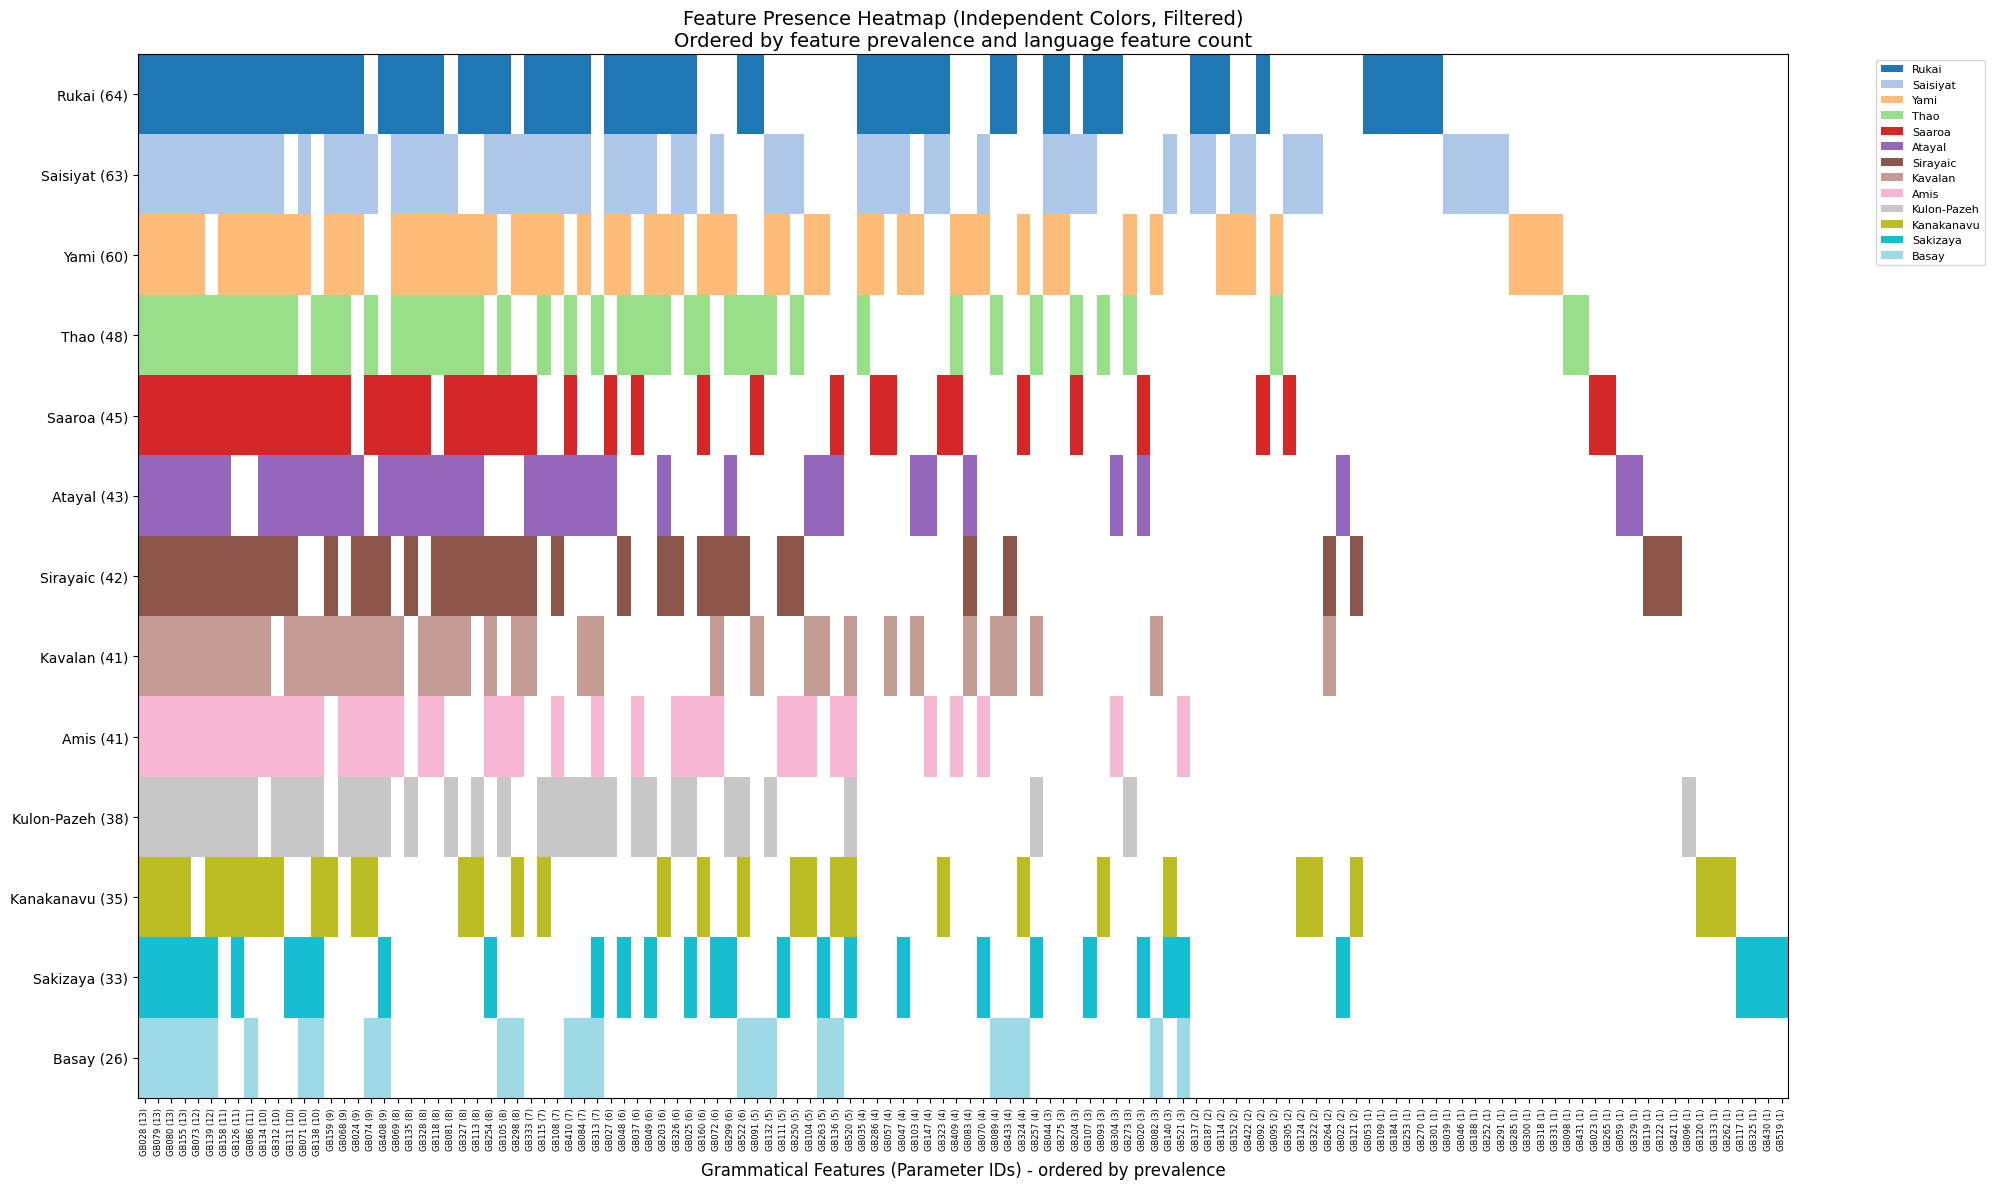

<Figure size 640x480 with 0 Axes>

In [18]:
# Filter out Taibei Hokkien language
taibei_id = lang_coords[lang_coords['Name'] == 'Taibei Hokkien']['Language_ID'].values
if len(taibei_id) > 0:
    taibei_id = taibei_id[0]
    feature_matrix_filtered = feature_matrix[feature_matrix.index != taibei_id].copy()
    lang_coords_filtered = lang_coords[lang_coords['Language_ID'] != taibei_id].copy()
    
    # Update clusters to match filtered languages
    clusters_filtered = [clusters[i] for i, lang_id in enumerate(feature_matrix.index) if lang_id != taibei_id]
else:
    feature_matrix_filtered = feature_matrix.copy()
    lang_coords_filtered = lang_coords.copy()
    clusters_filtered = clusters.copy()

# Remove features where all languages are 0
feature_sums = feature_matrix_filtered.sum(axis=0)
non_zero_features = feature_sums[feature_sums > 0].index
feature_matrix_filtered = feature_matrix_filtered[non_zero_features]

print(f"Original: {len(feature_matrix)} languages, {len(feature_matrix.columns)} features")
print(f"Filtered: {len(feature_matrix_filtered)} languages, {len(feature_matrix_filtered.columns)} features")

# Create heatmap of features by language, colored by cluster
fig, ax = plt.subplots(figsize=(20, 12))

# Order languages by total number of features they have (descending)
language_feature_counts = feature_matrix_filtered.sum(axis=1).sort_values(ascending=False)
ordered_languages = language_feature_counts.index

# Create a language ranking for tie-breaking
lang_rank = {lang_id: i for i, lang_id in enumerate(ordered_languages)}

# Order features by prevalence, with tie-breaking based on which languages have them
feature_counts = feature_matrix_filtered.sum(axis=0)

# For each feature, calculate a secondary sort key based on language rankings
feature_sort_keys = []
for feat in feature_matrix_filtered.columns:
    count = feature_counts[feat]
    # Get the languages that have this feature and sum their ranks (lower is better)
    langs_with_feature = feature_matrix_filtered[feature_matrix_filtered[feat] == 1].index
    avg_lang_rank = sum(lang_rank[lang] for lang in langs_with_feature) / len(langs_with_feature) if len(langs_with_feature) > 0 else float('inf')
    feature_sort_keys.append((feat, count, avg_lang_rank))

# Sort by count (descending), then by average language rank (ascending)
feature_sort_keys.sort(key=lambda x: (-x[1], x[2]))
ordered_features = [x[0] for x in feature_sort_keys]

# Reorder the feature matrix
feature_matrix_ordered = feature_matrix_filtered.loc[ordered_languages, ordered_features]

# Create a color array for the heatmap
# Shape: (n_languages, n_features)
heatmap_data = np.zeros((len(feature_matrix_ordered), len(feature_matrix_ordered.columns), 4))

# Assign independent colors to each language
n_langs_filtered = len(feature_matrix_ordered)
lang_colors = plt.cm.tab20(np.linspace(0, 1, n_langs_filtered))
lang_color_map = {lang_id: lang_colors[i] for i, lang_id in enumerate(ordered_languages)}

# For each language
for i, (lang_id, row) in enumerate(feature_matrix_ordered.iterrows()):
    # Get the independent color for this language
    lang_color = lang_color_map[lang_id]
    
    # For each feature
    for j, value in enumerate(row):
        if value == 1:
            heatmap_data[i, j] = lang_color
        else:
            heatmap_data[i, j] = [1, 1, 1, 1]  # White for 0 values

# Plot the heatmap
ax.imshow(heatmap_data, aspect='auto', interpolation='nearest')

# Set ticks and labels
ax.set_yticks(range(len(feature_matrix_ordered)))
ax.set_yticklabels([f"{lang_coords_filtered[lang_coords_filtered['Language_ID'] == lang_id]['Name'].iloc[0]} ({int(language_feature_counts[lang_id])})" 
                     for lang_id in ordered_languages], fontsize=10)

ax.set_xticks(range(len(feature_matrix_ordered.columns)))
ax.set_xticklabels([f"{feat} ({int(feature_counts[feat])})" for feat in ordered_features], 
                    rotation=90, fontsize=6)
ax.set_title('Feature Presence Heatmap (Independent Colors, Filtered)\nOrdered by feature prevalence and language feature count', fontsize=14)
ax.set_xlabel('Grammatical Features (Parameter IDs) - ordered by prevalence', fontsize=12)
# Add a legend for languages
legend_elements = [Patch(facecolor=lang_color_map[lang_id], 
                         label=f"{lang_coords_filtered[lang_coords_filtered['Language_ID'] == lang_id]['Name'].iloc[0]}")
                   for lang_id in ordered_languages]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()

plt.show()
plt.tight_layout()
plt.show()

Total number of bits (features): 124
	AND Similarity (shared 1s):
		Average: 23.01, Min: 9, Max: 43
	XNOR Similarity (total agreement):
		Average: 80.95, Min: 61, Max: 96


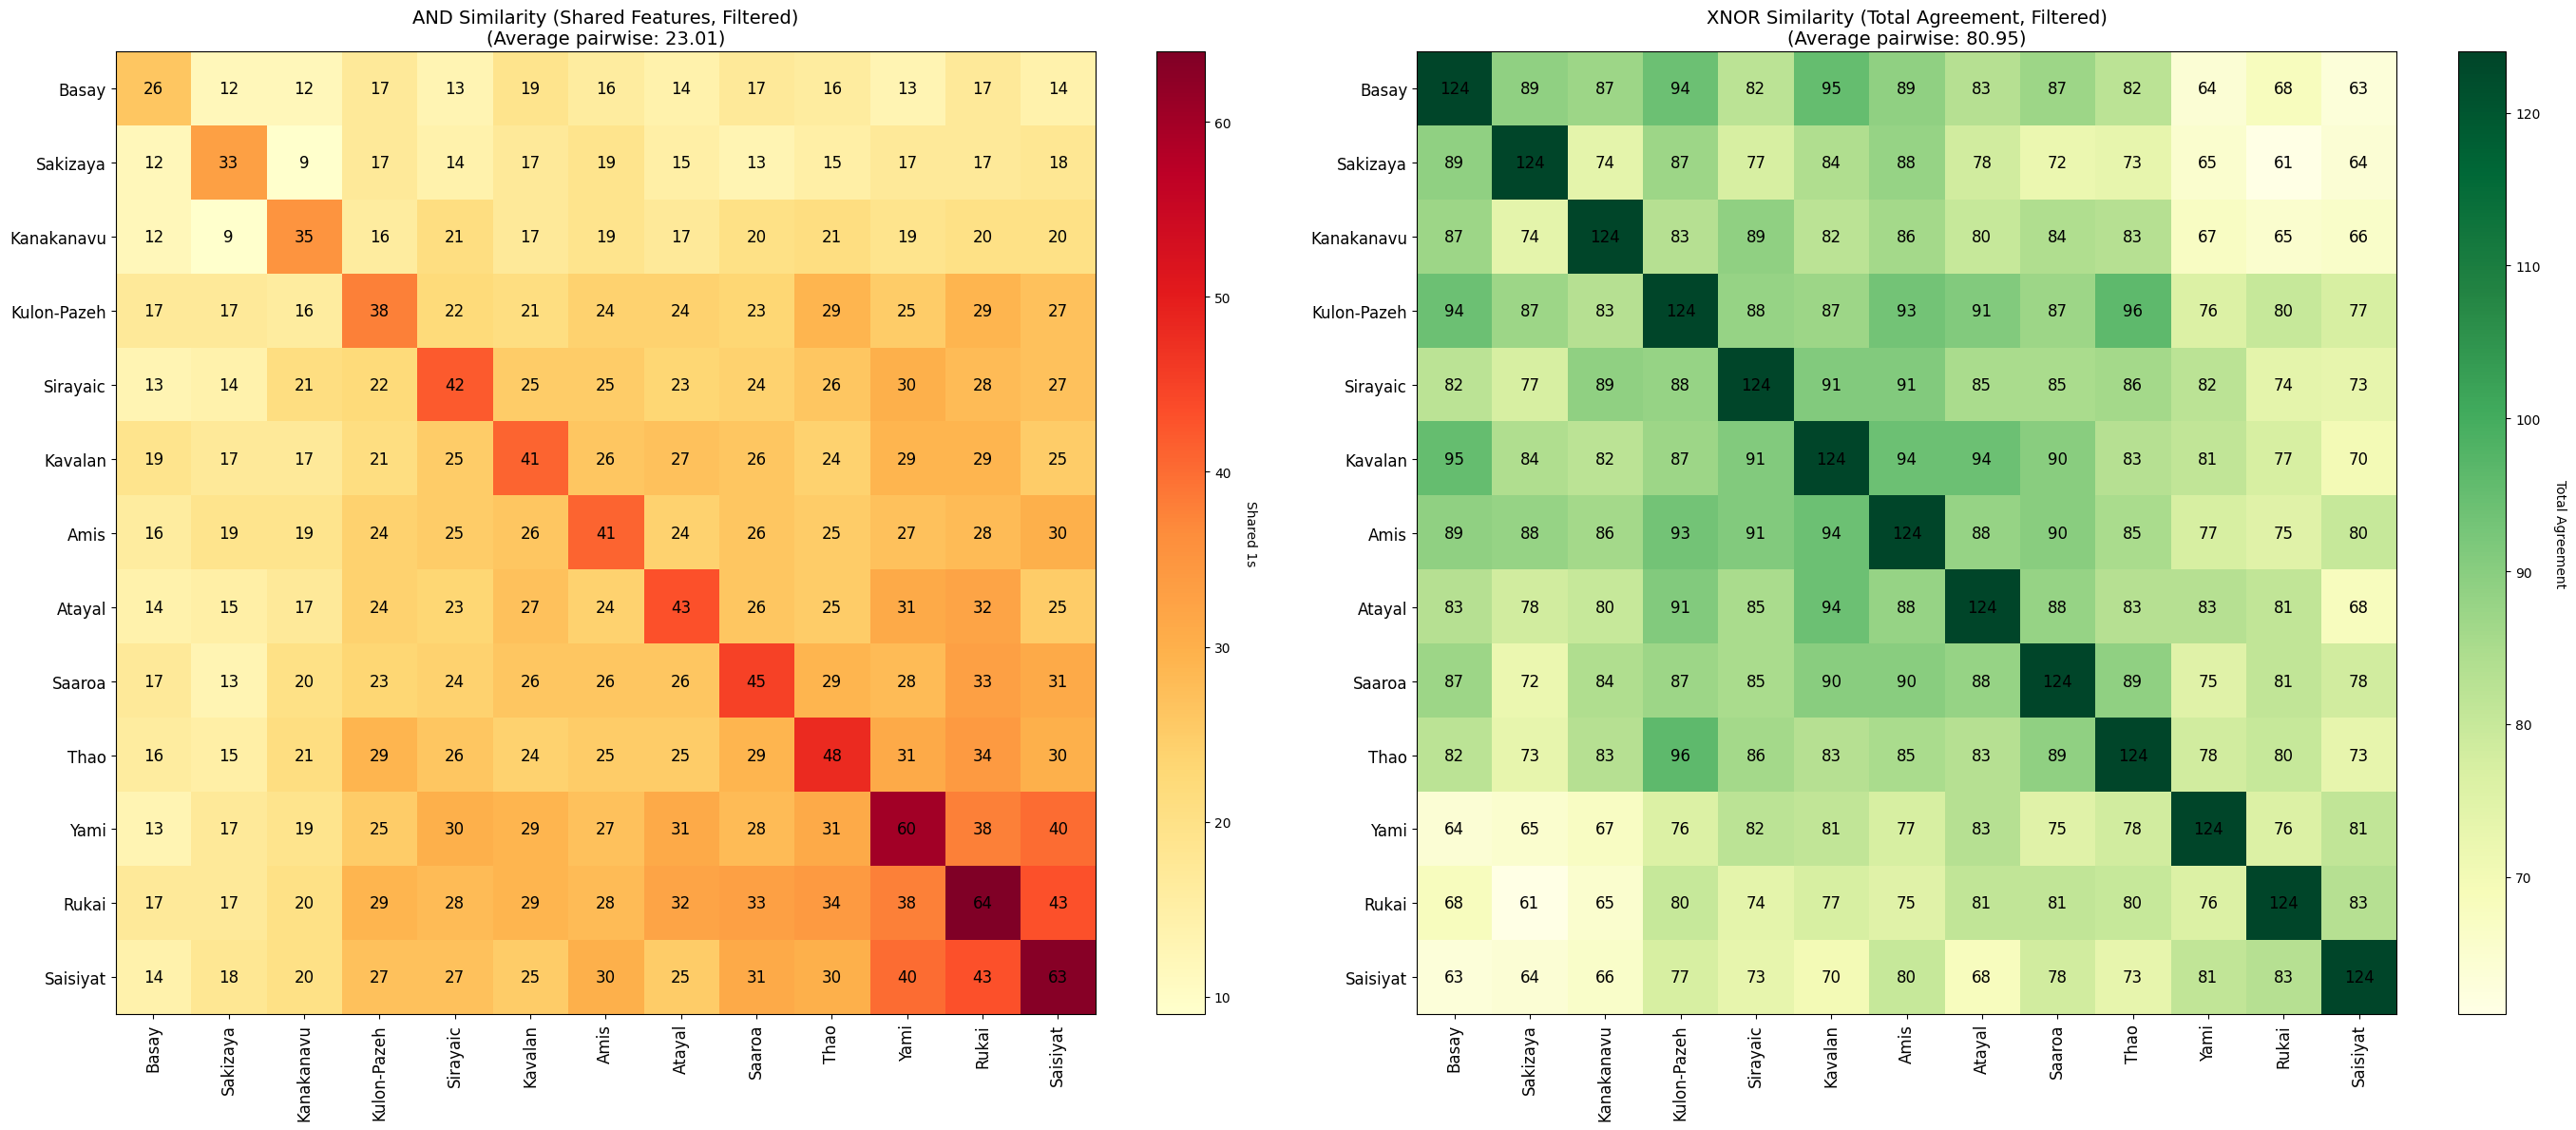

In [19]:
n_langs = len(feature_matrix_filtered)
n_features = len(feature_matrix_filtered.columns)

# Matrix 1: AND similarity (number of shared 1s)
and_similarity_matrix = np.zeros((n_langs, n_langs))

# Matrix 2: XNOR similarity (number of features where both agree - both 0 or both 1)
xnor_similarity_matrix = np.zeros((n_langs, n_langs))

# Calculate both similarity measures
for i in range(n_langs):
    for j in range(n_langs):
        if i == j:
            # Diagonal: total number of features for AND, total features for XNOR
            and_similarity_matrix[i, j] = feature_matrix_filtered.iloc[i].sum()
            xnor_similarity_matrix[i, j] = n_features
        else:
            # AND: Count features where both languages have value 1
            shared_ones = ((feature_matrix_filtered.iloc[i] == 1) & (feature_matrix_filtered.iloc[j] == 1)).sum()
            and_similarity_matrix[i, j] = shared_ones
            
            # XNOR: Count features where both agree (both 0 or both 1)
            both_zero = ((feature_matrix_filtered.iloc[i] == 0) & (feature_matrix_filtered.iloc[j] == 0)).sum()
            both_one = shared_ones
            xnor_similarity_matrix[i, j] = both_zero + both_one

# Calculate average pairwise similarities (excluding diagonal)
upper_triangle_indices = np.triu_indices(n_langs, k=1)

and_pairwise = and_similarity_matrix[upper_triangle_indices]
avg_and = and_pairwise.mean()

xnor_pairwise = xnor_similarity_matrix[upper_triangle_indices]
avg_xnor = xnor_pairwise.mean()

print(f"Total number of bits (features): {n_features}")
print(f"\tAND Similarity (shared 1s):")
print(f"\t\tAverage: {avg_and:.2f}, Min: {and_pairwise.min():.0f}, Max: {and_pairwise.max():.0f}")
print(f"\tXNOR Similarity (total agreement):")
print(f"\t\tAverage: {avg_xnor:.2f}, Min: {xnor_pairwise.min():.0f}, Max: {xnor_pairwise.max():.0f}")

# Use hierarchical clustering on AND similarity for ordering
max_similarity = and_similarity_matrix.max()
distance_matrix = max_similarity - and_similarity_matrix
np.fill_diagonal(distance_matrix, 0)

linkage_matrix = linkage(squareform(distance_matrix), method='average')
dendro = dendrogram(linkage_matrix, no_plot=True)
sorted_indices = dendro['leaves']

# Reorder both matrices with the same ordering
and_matrix_sorted = and_similarity_matrix[sorted_indices, :][:, sorted_indices]
xnor_matrix_sorted = xnor_similarity_matrix[sorted_indices, :][:, sorted_indices]

lang_names = [lang_coords_filtered[lang_coords_filtered['Language_ID'] == lang_id]['Name'].iloc[0] for lang_id in feature_matrix_filtered.index]
lang_names_sorted = [lang_names[i] for i in sorted_indices]

# Create side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))

# Plot 1: AND similarity
im1 = ax1.imshow(and_matrix_sorted, cmap='YlOrRd', aspect='auto')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Shared 1s', rotation=270, labelpad=20)

ax1.set_xticks(range(n_langs))
ax1.set_yticks(range(n_langs))
ax1.set_xticklabels(lang_names_sorted, rotation=90, fontsize=12)
ax1.set_yticklabels(lang_names_sorted, fontsize=12)

for i in range(n_langs):
    for j in range(n_langs):
        ax1.text(j, i, f'{int(and_matrix_sorted[i, j])}',
                ha="center", va="center", color="black", fontsize=12)

ax1.set_title(f'AND Similarity (Shared Features, Filtered)\n(Average pairwise: {avg_and:.2f})', fontsize=14)

# Plot 2: XNOR similarity
im2 = ax2.imshow(xnor_matrix_sorted, cmap='YlGn', aspect='auto')
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Total Agreement', rotation=270, labelpad=20)

ax2.set_xticks(range(n_langs))
ax2.set_yticks(range(n_langs))
ax2.set_xticklabels(lang_names_sorted, rotation=90, fontsize=12)
ax2.set_yticklabels(lang_names_sorted, fontsize=12)

for i in range(n_langs):
    for j in range(n_langs):
        ax2.text(j, i, f'{int(xnor_matrix_sorted[i, j])}',
                ha="center", va="center", color="black", fontsize=12)

ax2.set_title(f'XNOR Similarity (Total Agreement, Filtered)\n(Average pairwise: {avg_xnor:.2f})', fontsize=14)

plt.tight_layout()
plt.show()

Found file: /home/rizfn/github/babel-transition/src/paper_draft/2D/outputs/populationTimeseries/L_256_B_16/g_1_a_0.2_mu_1e-05.tsv
Timestep 20000: 27 total languages
Top 15 languages represent 63374 / 65536 = 96.7% of population
Total number of bits (features): 16
	AND Similarity (shared 1s):
		Average: 4.58, Min: 2, Max: 7
	XNOR Similarity (total agreement):
		Average: 7.56, Min: 3, Max: 13


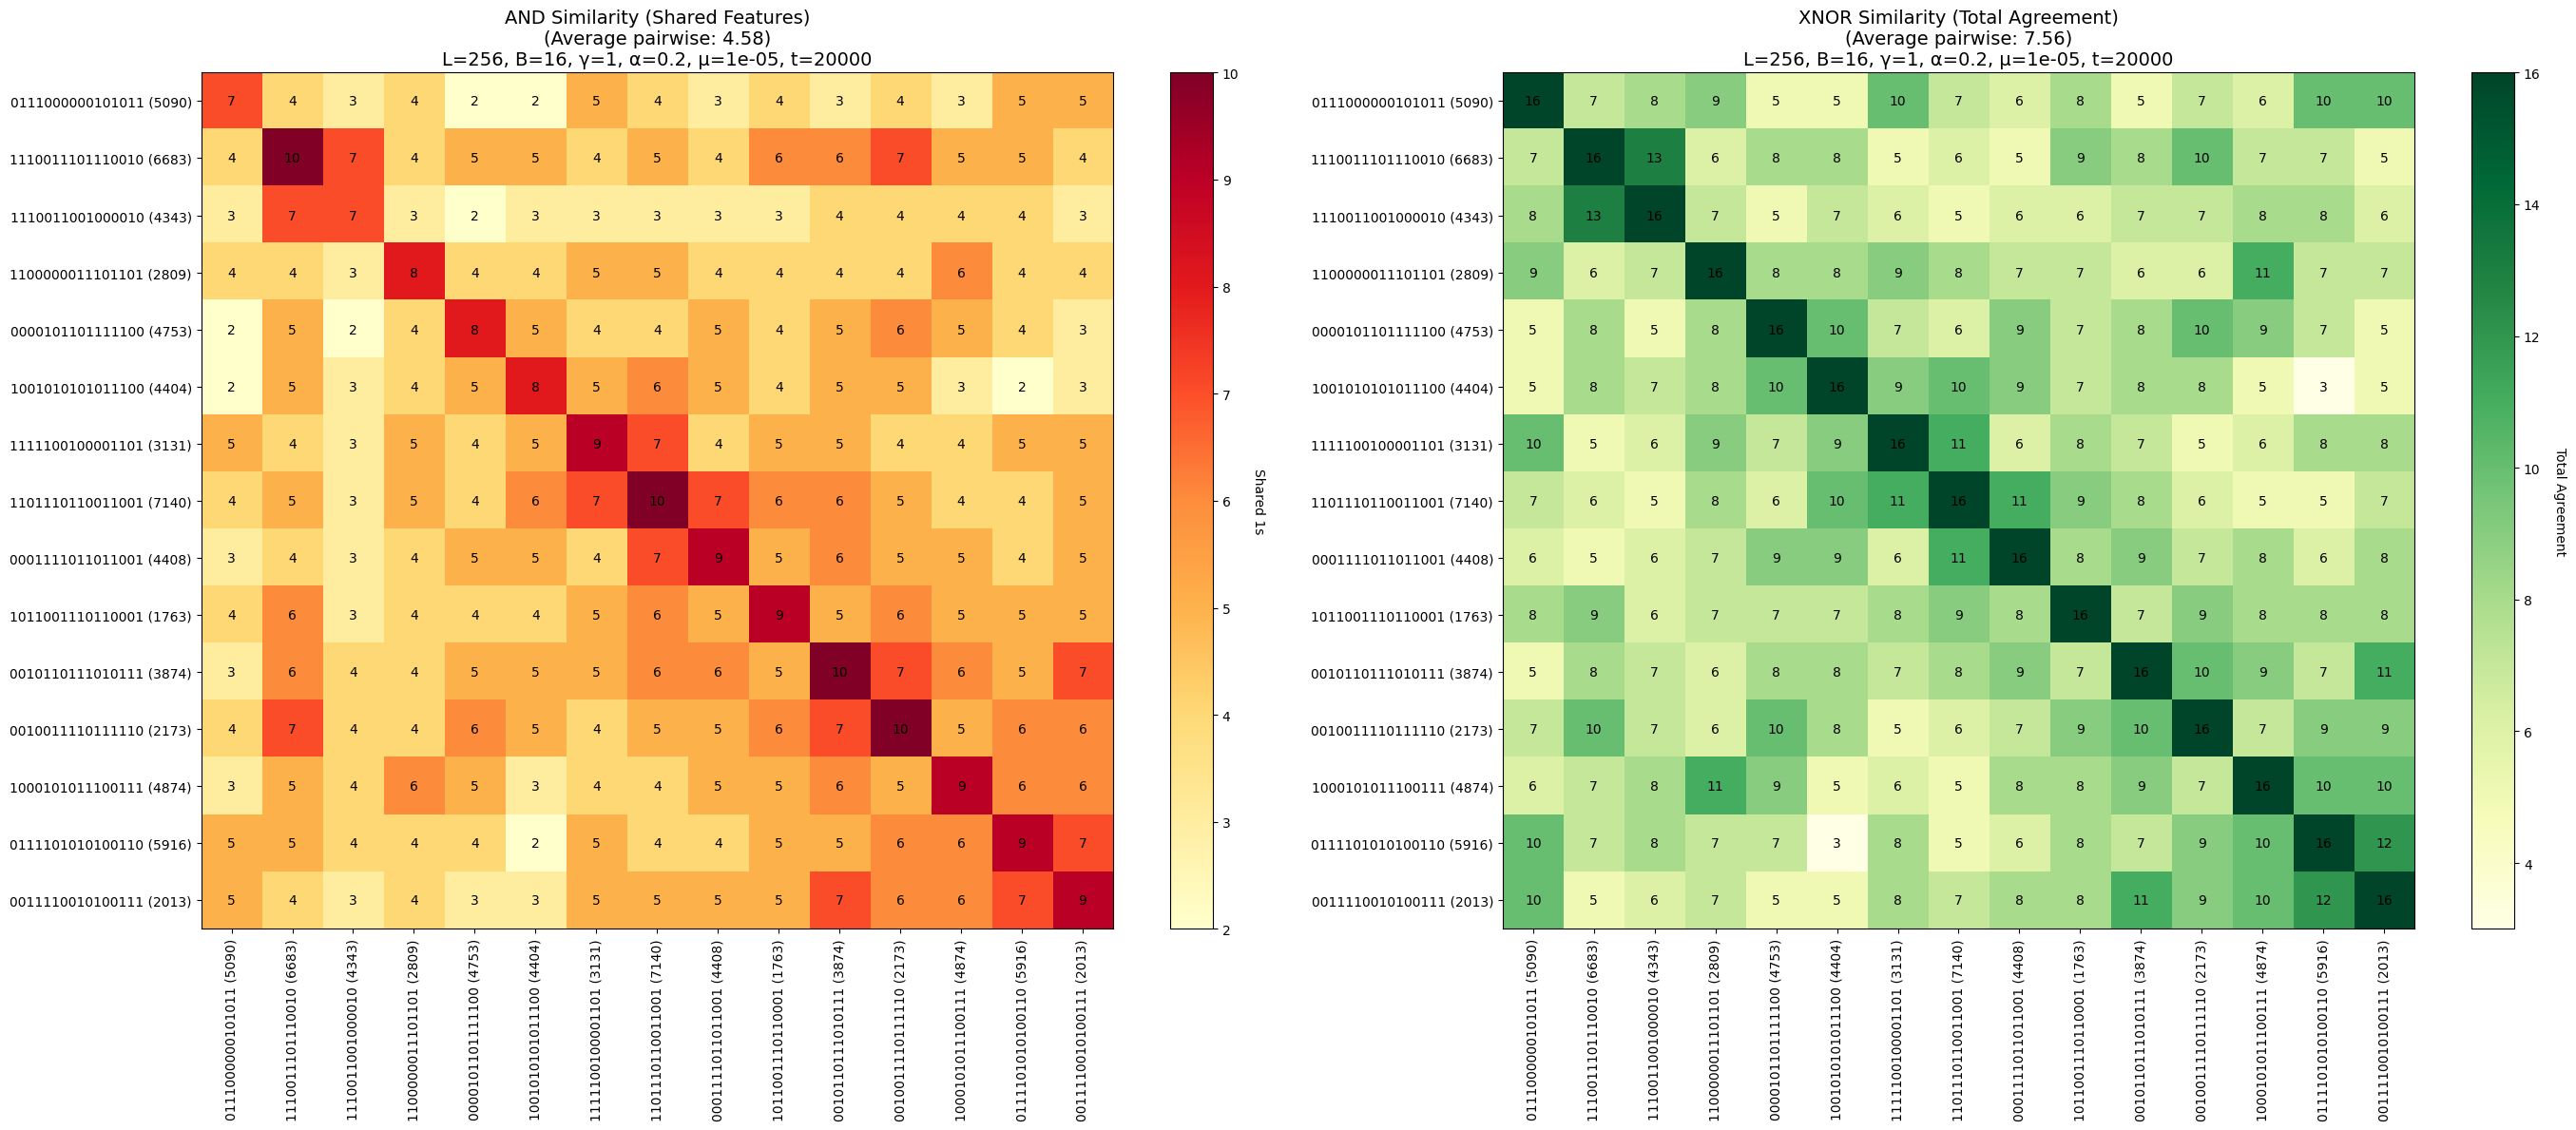

In [32]:
# Parameters
L = 256
B = 16
gamma = 1
alpha = 0.2
mu = 1e-05
timestep = 20000  # Which timestep to analyze
top_langs = 15

# Find and load the data file
def find_file_for_params(L, B, gamma, alpha, mu):
    """Find the file corresponding to given parameters."""
    # Try direct path first
    base_path = "/home/rizfn/github/babel-transition/src"
    pattern = os.path.join(
        base_path,
        f"paper_draft/2D/outputs/populationTimeseries/L_{L}_B_{B}/g_{gamma}_a_{alpha}_mu_{mu}.tsv"
    )
    if os.path.exists(pattern):
        return pattern
    
    # Try to find file with scientific notation for mu
    folder = os.path.join(
        base_path,
        f"paper_draft/2D/outputs/populationTimeseries/L_{L}_B_{B}"
    )
    if not os.path.exists(folder):
        return None
    
    import re
    for fname in os.listdir(folder):
        if re.fullmatch(rf"g_{gamma}_a_{alpha}_mu_.*\.tsv", fname):
            mu_match = re.search(r'mu_([0-9eE\.\+-]+)', fname)
            if mu_match:
                mu_in_file = float(mu_match.group(1))
                if f"mu_{mu}" in fname or np.isclose(float(mu), mu_in_file, rtol=1e-8):
                    return os.path.join(folder, fname)
    return None

def parse_population_line(line):
    """Parse a single line from population timeseries format."""
    parts = line.strip().split('\t')
    if len(parts) < 2:
        return None, None
    
    step = int(parts[0])
    population_counts = {}
    
    # Parse each bitstring,count pair
    for i in range(1, len(parts)):
        if ',' in parts[i]:
            bitstring, count_str = parts[i].split(',')
            population_counts[bitstring] = int(count_str)
    
    return step, population_counts

# Load data
filename = find_file_for_params(L, B, gamma, alpha, mu)
if filename is None:
    print(f"No file found for L={L}, B={B}, gamma={gamma}, alpha={alpha}, mu={mu}")
else:
    print(f"Found file: {filename}")
    
    # Read the specific timestep
    target_population = None
    with open(filename, "r") as f:
        for line in f:
            step, pop_counts = parse_population_line(line)
            if step == timestep:
                target_population = pop_counts
                break
    
    if target_population is None:
        print(f"Timestep {timestep} not found in file")
    else:
        # Get top languages by population
        sorted_langs = sorted(target_population.items(), key=lambda x: x[1], reverse=True)
        top_langs_list = sorted_langs[:top_langs]
        
        print(f"Timestep {timestep}: {len(target_population)} total languages")
        print(f"Top {top_langs} languages represent {sum(count for _, count in top_langs_list)} / {sum(target_population.values())} = {sum(count for _, count in top_langs_list)/sum(target_population.values()):.1%} of population")
        
        # Create feature matrix from bitstrings
        bitstrings = [lang for lang, _ in top_langs_list]
        sim_feature_matrix = pd.DataFrame(
            [[int(bit) for bit in bitstring] for bitstring in bitstrings],
            index=[f"{bs} ({count})" for bs, count in top_langs_list]
        )
        
        n_langs = len(sim_feature_matrix)
        n_features = len(sim_feature_matrix.columns)
        
        # Matrix 1: AND similarity (number of shared 1s)
        and_similarity_matrix = np.zeros((n_langs, n_langs))
        
        # Matrix 2: XNOR similarity (number of features where both agree)
        xnor_similarity_matrix = np.zeros((n_langs, n_langs))
        
        # Calculate both similarity measures
        for i in range(n_langs):
            for j in range(n_langs):
                if i == j:
                    and_similarity_matrix[i, j] = sim_feature_matrix.iloc[i].sum()
                    xnor_similarity_matrix[i, j] = n_features
                else:
                    # AND: Count features where both languages have value 1
                    shared_ones = ((sim_feature_matrix.iloc[i] == 1) & (sim_feature_matrix.iloc[j] == 1)).sum()
                    and_similarity_matrix[i, j] = shared_ones
                    
                    # XNOR: Count features where both agree
                    both_zero = ((sim_feature_matrix.iloc[i] == 0) & (sim_feature_matrix.iloc[j] == 0)).sum()
                    both_one = shared_ones
                    xnor_similarity_matrix[i, j] = both_zero + both_one
        
        # Calculate average pairwise similarities
        upper_triangle_indices = np.triu_indices(n_langs, k=1)
        
        and_pairwise = and_similarity_matrix[upper_triangle_indices]
        avg_and = and_pairwise.mean()
        
        xnor_pairwise = xnor_similarity_matrix[upper_triangle_indices]
        avg_xnor = xnor_pairwise.mean()
        
        print(f"Total number of bits (features): {n_features}")
        print(f"\tAND Similarity (shared 1s):")
        print(f"\t\tAverage: {avg_and:.2f}, Min: {and_pairwise.min():.0f}, Max: {and_pairwise.max():.0f}")
        print(f"\tXNOR Similarity (total agreement):")
        print(f"\t\tAverage: {avg_xnor:.2f}, Min: {xnor_pairwise.min():.0f}, Max: {xnor_pairwise.max():.0f}")
        
        # Use hierarchical clustering on AND similarity for ordering
        max_similarity = and_similarity_matrix.max()
        distance_matrix = max_similarity - and_similarity_matrix
        np.fill_diagonal(distance_matrix, 0)
        
        linkage_matrix = linkage(squareform(distance_matrix), method='average')
        dendro = dendrogram(linkage_matrix, no_plot=True)
        sorted_indices = dendro['leaves']
        
        # Reorder both matrices
        and_matrix_sorted = and_similarity_matrix[sorted_indices, :][:, sorted_indices]
        xnor_matrix_sorted = xnor_similarity_matrix[sorted_indices, :][:, sorted_indices]
        
        lang_labels = list(sim_feature_matrix.index)
        lang_labels_sorted = [lang_labels[i] for i in sorted_indices]
        
        # Create side-by-side heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12))
        
        # Plot 1: AND similarity
        im1 = ax1.imshow(and_matrix_sorted, cmap='YlOrRd', aspect='auto')
        cbar1 = plt.colorbar(im1, ax=ax1)
        cbar1.set_label('Shared 1s', rotation=270, labelpad=20)
        
        ax1.set_xticks(range(n_langs))
        ax1.set_yticks(range(n_langs))
        ax1.set_xticklabels(lang_labels_sorted, rotation=90, fontsize=10)
        ax1.set_yticklabels(lang_labels_sorted, fontsize=10)
        
        for i in range(n_langs):
            for j in range(n_langs):
                ax1.text(j, i, f'{int(and_matrix_sorted[i, j])}',
                        ha="center", va="center", color="black", fontsize=10)
        
        ax1.set_title(f'AND Similarity (Shared Features)\n(Average pairwise: {avg_and:.2f})\nL={L}, B={B}, γ={gamma}, α={alpha}, μ={mu}, t={timestep}', fontsize=14)
        
        # Plot 2: XNOR similarity
        im2 = ax2.imshow(xnor_matrix_sorted, cmap='YlGn', aspect='auto')
        cbar2 = plt.colorbar(im2, ax=ax2)
        cbar2.set_label('Total Agreement', rotation=270, labelpad=20)
        
        ax2.set_xticks(range(n_langs))
        ax2.set_yticks(range(n_langs))
        ax2.set_xticklabels(lang_labels_sorted, rotation=90, fontsize=10)
        ax2.set_yticklabels(lang_labels_sorted, fontsize=10)
        
        for i in range(n_langs):
            for j in range(n_langs):
                ax2.text(j, i, f'{int(xnor_matrix_sorted[i, j])}',
                        ha="center", va="center", color="black", fontsize=10)
        
        ax2.set_title(f'XNOR Similarity (Total Agreement)\n(Average pairwise: {avg_xnor:.2f})\nL={L}, B={B}, γ={gamma}, α={alpha}, μ={mu}, t={timestep}', fontsize=14)
        
        plt.tight_layout()
        plt.show()